# Отчет

Сразу скажу, что умные мысли привели лишь к ухудшению результата. Сработали несложная почистка данных и наивные идеи. Можно было дальше придумывать как улучшить, я этого не делал --  было некогда. 
Нотебук не очень связанный, скорее всего состоит из нескольких кусков, добавленных в разных моментов времени мною. Неудачные фрагменты и графики всякие удалены.

### Методы

#####*Как пробовали предобрабатывать признаки (да -- помогло, нет -- не помогло):*


*   `CountVectorizer()` (нет)
*   `OrdinalEncoder()` (нет)
*   `OneHotEncoder()` (нет)
*   `StandardScaler()` (да? там как бы дерево, но без standardScaler стало хуже)
*   наивные конвертеры-представители данных в числовом виде (да)
*   удаление выбросов (сначала нет, а потом делал по-другому и сработало)
*   замена нелогичных нулей на `Nan` (да?)
*   замена `Nan` на медиану по группам (да)

#####*Какие модели и с какими параметрами пробовали:*


*   `CatBoostClassifier()` -- маленькое число iterations, к сожалению, дало не очень хороший результат. Порядка 3000 с другой стороны сработало неплохо.


### Результаты

#####*Наблюдения, истории успеха и зря потраченные усилия; какие выводы?*
*   **object_count** собрал в кучу все важные объекты: sports_count, malls_count, и т.д. Оставил одну фичу: `object_count`. Помогло.
*   **timestamp:** очевидно -- полезная штука. Использовал дополнительные данные, см. ниже.
*   **Nan:** замена Nan-ов на медиану/моду, несомненно помогло. Группировка в основном делалась по кварталам, но не только.
*   **Кольца всякие:** тут дело сложное: внутри или снаружи кольца по данным сложно понять. Думал убрать кольца, оставить только расстояние от фикс. объекта (Кремль, например), но не помогло. Так что не трогал кольца.
*   **Инфляция:** долго думал, см. timestamp. И еще, домножил в конце на какой-то коэфф. Странно, но помогло.
*   **district_area:** бывают окраины с большой площадью, а бывают с маленькой. Думал убрать и просто кодировать district_name -- не помогло. Не исключаю, что я что-то не так делал:))
*   **price/m^2:** Рассматривать не цену за квартиру, а цену за квадрат: `result_price/total_area`. Я был более чем уверен, что это поможет, но нет. В этот момент я думал бросить задание и не стараться больше:)
*   **связь total_area - rooms_num, kitchen_area, living_area:** делал кое что, совершенно не помогло. 
*   **correlated features:** убирал, заменял, скомбинировал, ничего не сработало. В итоге оставил как есть (я и не говорю, что мое решение идеальное. Я даже не говорю, что я пытался, чтобы оно было идеальным:)))
*   еще много чего пробовал, прошу прощения, даже не помню некоторые мысли...


**Вывод:** даже не знаю, что сказать. Спасибо за контест, я заодно познакомился с урбанистикой Москвы, теперь готов работать инженером там:)) Без шуток, было интересно поисследовать какие-то факты про мск, урбанистику, структуру, рынок квартир, и тп:)

---
---
---

# Notebook

## Datasets

In [76]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### Все библиотеки

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error

from catboost import Pool, CatBoostRegressor

from pandas.api.types import is_numeric_dtype

%matplotlib inline

#### Train + Test

In [78]:
df = pd.read_csv("train.csv")
df.head()

,district_area,road_distance_1,road_distance_2,year_of_construction,bulvar_ring_km,bus_station_distance,cafe_count,fitness_center_distance,floor,district_population,...,product_type,public_transport_station_distance,sadovoe_km,base_school_distance,sport_count,state,district_name,timestamp,malls_count,railway_station_distance
0,6.407578e+06,1.422391,3.830951,NaN,13.675657,24.292406,152,0.485841,4.0,86206,...,Investment,3.299822,13.100618,0.177975,52,NaN,Bibirevo,2011-08-20,52,14.231961
1,9.589337e+06,2.887377,3.103996,NaN,8.132640,5.706113,177,0.668364,3.0,76284,...,Investment,0.783160,6.444333,0.273345,66,NaN,Nagatinskij Zaton,2011-08-23,40,9.242586
2,4.808270e+06,0.647250,2.927487,NaN,8.054252,6.710302,122,0.733101,2.0,101982,...,Investment,3.945073,6.963403,0.158072,67,NaN,Tekstil'shhiki,2011-08-27,35,9.540544
3,1.258354e+07,2.677824,2.780449,NaN,18.309433,6.734618,61,0.623484,9.0,21155,...,Investment,1.579164,17.457198,0.236455,26,NaN,Mitino,2011-09-01,22,17.478380
4,8.398461e+06,1.721834,3.133531,NaN,0.787593,1.423428,2283,0.220288,4.0,28179,...,Investment,0.857764,0.046810,0.376838,195,NaN,Basmannoe,2011-09-05,114,1.595898


In [79]:
dft = pd.read_csv("test.csv")
dft.head()

,district_area,road_distance_1,road_distance_2,year_of_construction,bulvar_ring_km,bus_station_distance,cafe_count,fitness_center_distance,floor,district_population,...,product_type,public_transport_station_distance,sadovoe_km,base_school_distance,sport_count,state,district_name,timestamp,malls_count,railway_station_distance
0,25536296.81,2.808077,3.688405,NaN,21.038561,17.366661,20,1.519553,15.0,17790,...,OwnerOccupier,7.560163,19.868997,1.234235,11,NaN,Poselenie Vnukovskoe,2015-01-05,4,25.699461
1,25536296.81,2.959485,3.474052,NaN,21.352564,17.845449,20,1.884939,2.0,17790,...,OwnerOccupier,3.357039,20.183980,1.545730,10,1.0,Poselenie Vnukovskoe,2015-01-06,4,26.054344
2,40366999.51,0.478623,6.886762,0.0,22.548909,15.269596,14,1.869427,24.0,7341,...,OwnerOccupier,1.603221,21.380555,3.532680,8,1.0,Poselenie Moskovskij,2015-01-10,3,30.927687
3,66772450.69,1.444098,4.585951,NaN,21.833697,12.909037,14,1.080227,8.0,13890,...,OwnerOccupier,10.128646,20.670206,3.419971,7,NaN,Poselenie Sosenskoe,2015-01-10,3,24.613188
4,5704502.19,0.630552,1.422580,1989.0,5.519649,7.835220,611,1.305352,9.0,1362363,...,Investment,1.949641,4.377551,0.728850,105,3.0,Akademicheskoe,2015-01-10,44,7.911929


## Data engineering (мда)

- храним `id` и `result_price`
- исследование Nan-ов
- object_count = SUM(`%%%%_count`)
- timestamp
- обработка year_construction, state, wall_material, с которыми серьезные проблемы с точки зрения данных (история такая: в начале я их убрал, а потом вернул, обработав их. Это и дало хороший скор).

### Исследование данных

#### ID, result_price

In [80]:
test_ids = dft['id']
test_ids.head()

0    27235
1    27236
2    27237
3    27238
4    27239
Name: id, dtype: int64

In [81]:
rp = df['result_price']
df.drop(['result_price'], axis=1, inplace=True)
df['result_price'] = rp

#### Nan analysis

In [82]:
print("TRAIN_DATAFRAME")

for col in df.columns:
    length = df[col].shape[0]
    nan_count = df[col].isna().sum()
    if nan_count > 0:
        print(f"Column {col}, dtype {df[col].dtype} has:\n {nan_count} NaNs out of {length} entries \n")

TRAIN_DATAFRAME
Column year_of_construction, dtype float64 has:
 12918 NaNs out of 27232 entries 

Column floor, dtype float64 has:
 167 NaNs out of 27232 entries 

Column kitchen_area, dtype float64 has:
 9572 NaNs out of 27232 entries 

Column living_area, dtype float64 has:
 5588 NaNs out of 27232 entries 

Column wall_material, dtype float64 has:
 9572 NaNs out of 27232 entries 

Column floors_num, dtype float64 has:
 9572 NaNs out of 27232 entries 

Column metro_minutes, dtype float64 has:
 16 NaNs out of 27232 entries 

Column rooms_num, dtype float64 has:
 9572 NaNs out of 27232 entries 

Column state, dtype float64 has:
 13097 NaNs out of 27232 entries 



In [83]:
print("TEST_DATAFRAME")

for col in dft.columns:
    length = dft[col].shape[0]
    nan_count = dft[col].isna().sum()
    if nan_count > 0:
        print(f"Column {col}, dtype {df[col].dtype} has:\n {nan_count} NaNs out of {length} entries \n")

TEST_DATAFRAME
Column year_of_construction, dtype float64 has:
 687 NaNs out of 3239 entries 

Column living_area, dtype float64 has:
 795 NaNs out of 3239 entries 

Column metro_minutes, dtype float64 has:
 9 NaNs out of 3239 entries 

Column state, dtype float64 has:
 462 NaNs out of 3239 entries 



#### Correlation between features

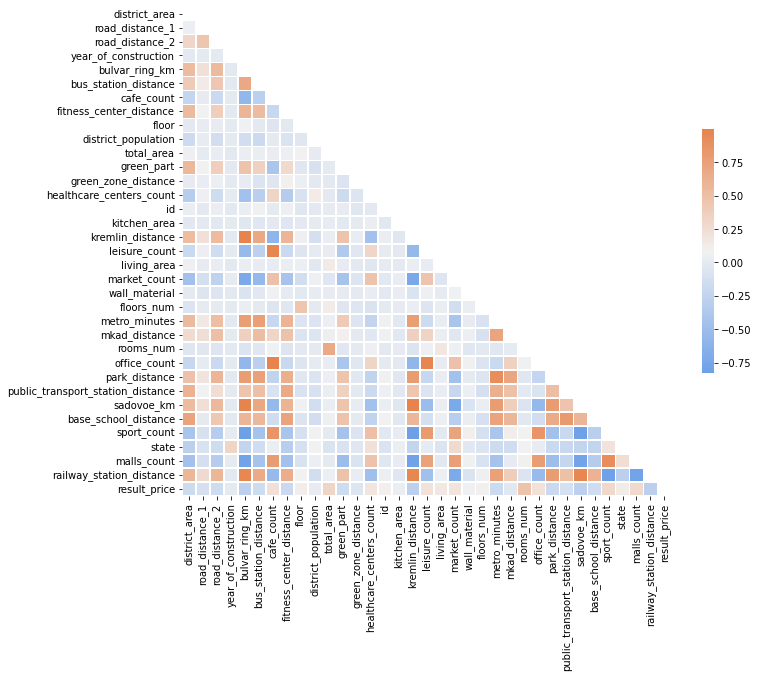

In [84]:
# готовый код

corr = df.select_dtypes(exclude=['object']).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 30, l=65, center="light", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [85]:
corr.iloc[:, 0].sort_values()

market_count                        -0.448592
malls_count                         -0.446947
sport_count                         -0.413469
healthcare_centers_count            -0.321600
state                               -0.286133
cafe_count                          -0.225554
office_count                        -0.214410
leisure_count                       -0.194609
result_price                        -0.164442
district_population                 -0.162225
floors_num                          -0.067838
rooms_num                           -0.040303
kitchen_area                        -0.018830
year_of_construction                -0.004804
floor                               -0.001903
wall_material                        0.001505
green_zone_distance                  0.014818
id                                   0.038218
road_distance_1                      0.042915
total_area                           0.057579
living_area                          0.060387
mkad_distance                     

#### Categorical data

In [86]:
df.dtypes

district_area                        float64
road_distance_1                      float64
road_distance_2                      float64
year_of_construction                 float64
bulvar_ring_km                       float64
bus_station_distance                 float64
cafe_count                             int64
fitness_center_distance              float64
floor                                float64
district_population                    int64
total_area                             int64
green_part                           float64
green_zone_distance                  float64
healthcare_centers_count               int64
id                                     int64
kitchen_area                         float64
kremlin_distance                     float64
leisure_count                          int64
living_area                          float64
market_count                           int64
wall_material                        float64
floors_num                           float64
metro_minu

In [87]:
for col in df.columns:
    if df[col].dtype == object:
        print(f"Column {col} is categorical. Unique values:\n{df[col].unique()}")

Column product_type is categorical. Unique values:
['Investment' 'OwnerOccupier']
Column district_name is categorical. Unique values:
['Bibirevo' 'Nagatinskij Zaton' "Tekstil'shhiki" 'Mitino' 'Basmannoe'
 'Nizhegorodskoe' "Sokol'niki" 'Koptevo' 'Kuncevo' 'Kosino-Uhtomskoe'
 'Zapadnoe Degunino' 'Presnenskoe' 'Lefortovo' "Mar'ino" "Kuz'minki"
 'Nagornoe' "Gol'janovo" 'Vnukovo' 'Juzhnoe Tushino' 'Severnoe Tushino'
 "Chertanovo Central'noe" 'Fili Davydkovo' 'Otradnoe' 'Novo-Peredelkino'
 'Bogorodskoe' 'Jaroslavskoe' 'Strogino' 'Hovrino' "Moskvorech'e-Saburovo"
 'Staroe Krjukovo' 'Ljublino' 'Caricyno' 'Veshnjaki' 'Danilovskoe'
 'Preobrazhenskoe' "Kon'kovo" 'Brateevo' 'Vostochnoe Izmajlovo'
 'Vyhino-Zhulebino' 'Donskoe' 'Novogireevo' 'Juzhnoe Butovo' 'Sokol'
 'Kurkino' 'Izmajlovo' 'Severnoe Medvedkovo' 'Rostokino'
 'Orehovo-Borisovo Severnoe' 'Ochakovo-Matveevskoe' 'Taganskoe'
 'Dmitrovskoe' 'Orehovo-Borisovo Juzhnoe' 'Teplyj Stan' 'Babushkinskoe'
 'Pokrovskoe Streshnevo' 'Obruchevskoe' 'Fil

Напоминаю, использовал всякие Encoders, не помогли почему-то. Или я одновременно поменял еще что-то другое, и стало хуже из-за этого "другого". Неважно уже в общем.

#### Графики всякие, которые удалены

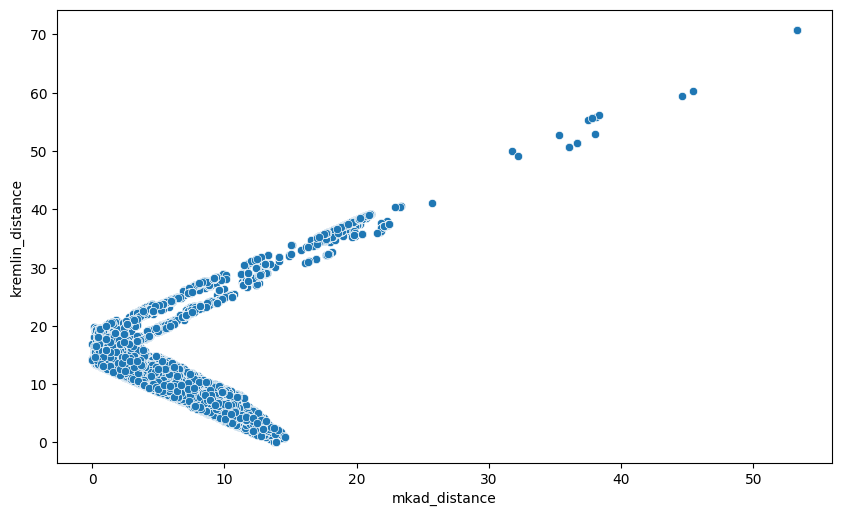

In [88]:
fig, scatter = plt.subplots(figsize = (10,6), dpi = 100)
scatter = sns.scatterplot(x = df['mkad_distance'], y = df['kremlin_distance'])
#scatter.set_xlim(left=1800, right=2100)
#scatter.set_ylim(bottom=-10, top=1e7);

### Обработка данных

#### object_count

In [89]:
df['object_count'] = df['cafe_count'] + df['healthcare_centers_count'] + df['leisure_count']
+ df['market_count'] + df['office_count'] + df['sport_count'] + df['malls_count']
dft['object_count'] = dft['cafe_count'] + dft['healthcare_centers_count'] + dft['leisure_count']
+ dft['market_count'] + dft['office_count'] + dft['sport_count'] + dft['malls_count']

df['object_count']

0         153
1         188
2         127
3          62
4        2378
         ... 
27227      14
27228      96
27229      45
27230      99
27231      67
Name: object_count, Length: 27232, dtype: int64

In [90]:
df = df.drop(['cafe_count', 'healthcare_centers_count', 'leisure_count', 'market_count', 'office_count', 'sport_count', 'malls_count'], axis=1)
dft = dft.drop(['cafe_count', 'healthcare_centers_count', 'leisure_count', 'market_count', 'office_count', 'sport_count', 'malls_count'], axis=1)
df

,district_area,road_distance_1,road_distance_2,year_of_construction,bulvar_ring_km,bus_station_distance,fitness_center_distance,floor,district_population,total_area,...,product_type,public_transport_station_distance,sadovoe_km,base_school_distance,state,district_name,timestamp,railway_station_distance,result_price,object_count
0,6.407578e+06,1.422391,3.830951,NaN,13.675657,24.292406,0.485841,4.0,86206,43,...,Investment,3.299822,13.100618,0.177975,NaN,Bibirevo,2011-08-20,14.231961,5850000,153
1,9.589337e+06,2.887377,3.103996,NaN,8.132640,5.706113,0.668364,3.0,76284,34,...,Investment,0.783160,6.444333,0.273345,NaN,Nagatinskij Zaton,2011-08-23,9.242586,6000000,188
2,4.808270e+06,0.647250,2.927487,NaN,8.054252,6.710302,0.733101,2.0,101982,43,...,Investment,3.945073,6.963403,0.158072,NaN,Tekstil'shhiki,2011-08-27,9.540544,5700000,127
3,1.258354e+07,2.677824,2.780449,NaN,18.309433,6.734618,0.623484,9.0,21155,89,...,Investment,1.579164,17.457198,0.236455,NaN,Mitino,2011-09-01,17.478380,13100000,62
4,8.398461e+06,1.721834,3.133531,NaN,0.787593,1.423428,0.220288,4.0,28179,77,...,Investment,0.857764,0.046810,0.376838,NaN,Basmannoe,2011-09-05,1.595898,16331452,2378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27227,6.677245e+07,1.444098,4.585951,NaN,21.833697,12.909037,1.080227,12.0,13890,44,...,OwnerOccupier,10.128646,20.670206,3.419971,1.0,Poselenie Sosenskoe,2014-12-31,24.613188,5524795,14
27228,1.175477e+07,3.393475,3.949786,2001.0,13.110351,8.283670,0.293622,6.0,165727,76,...,Investment,1.063260,11.854601,0.256448,4.0,Mar'ino,2014-12-31,15.549413,12800000,96
27229,8.889467e+06,1.056678,1.227452,2002.0,19.308299,1.770336,0.154368,15.0,78616,78,...,Investment,1.237274,17.923918,0.164885,3.0,Severnoe Butovo,2014-12-31,21.960635,15500000,45
27230,1.020722e+07,0.777074,0.795735,1975.0,11.448315,9.263037,0.150135,7.0,157010,54,...,Investment,1.416023,10.843521,0.391014,3.0,Ivanovskoe,2014-12-31,13.145832,8350000,99


#### timestamp + дополнительные данные

классная идея, с кем-то обсуждали, не то что очень помогло, но что-то хорошее дало

In [91]:
def timestamp_to_quarter(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    def to_season(x):
        month = x.month
        return month % 12 // 3 + 1
    def to_year(x):
        return x.year
    def to_month(x):
        return x.month
    def to_q(x):
        month = x.month
        return (month - 1) % 12 // 3 + 1
    
    df['season'] = df['timestamp'].apply(to_season).astype('category')
    df['year'] = df['timestamp'].apply(to_year)
    df['month'] = df['timestamp'].apply(to_month).astype('category')
    df['quarter'] = df['timestamp'].apply(to_q).astype('category')
    
    df.drop(['timestamp'], axis=1, inplace=True)
    
    return df

In [92]:
df = timestamp_to_quarter(df)
dft = timestamp_to_quarter(dft)

In [93]:
out_data = pd.read_excel("2011-2015.xls")
out_data

,Unnamed: 0,2011.1,2011.2,2011.3,2011.4,2012.1,2012.2,2012.3,2012.4,2013.1,...,2013.3,2013.4,2014.1,2014.2,2014.3,2014.4,2015.1,2015.2,2015.3,2015.4
0,NaN,1.00,2.00,3.00,4.00,1.00,2.00,3.00,4.00,1.00,...,3.00,4.00,1.00,2.00,3.00,4.00,1.00,2.00,3.00,4.00
1,Вторичный,162419.89,163426.85,162952.13,163202.77,166679.88,168869.88,172260.14,176319.51,182005.09,...,178971.23,177899.02,179146.33,183080.73,184573.86,191267.84,188118.41,192986.91,192291.80,187743.30
2,Первичный,125954.47,126535.69,128044.73,129523.52,127344.75,130983.31,130532.46,129965.62,140689.08,...,149956.09,151517.17,166946.33,170069.81,170073.12,174538.14,173715.83,172923.74,175056.84,182292.43


In [94]:
out_data.drop(0, inplace=True)
out_data = out_data.set_index("Unnamed: 0")

In [95]:
out_data['2011.1']['Первичный']

125954.47

In [96]:
def q_mean(y, q):
    y_q = str(y) + '.' + str(q)
    return (out_data[y_q]['Первичный'] + out_data[y_q]['Вторичный']) / 2

def coeff(bpr, npr):
    return bpr / npr

def to_test_prices(x):
    base_price = (q_mean(2015, 1) + q_mean(2015, 2)) / 2
    now_price = q_mean(x['year'], x['quarter'])
    coef = coeff(base_price, now_price)
    
    flat_price = x['result_price']

    return flat_price * coef

In [97]:
df['result_price'] = df.apply(to_test_prices, axis=1)
df.drop(['quarter'], axis=1, inplace=True)
dft.drop(['quarter'], axis=1, inplace=True)

#### year_construction


In [98]:
df.loc[(df['year_of_construction'] <= 1500) | (df['year_of_construction'] >= 2100), 'year_of_construction'] = np.nan
dft.loc[(dft['year_of_construction'] <= 1500) | (dft['year_of_construction'] >= 2100), 'year_of_construction'] = np.nan

In [99]:
df['year_of_construction'] = df.groupby(by='district_name')['year_of_construction'].transform(lambda r: r.fillna(r.median()))
df['year_of_construction'] = df['year_of_construction'].astype(int)

dft['year_of_construction'] = dft.groupby(by='district_name')['year_of_construction'].transform(lambda r: r.fillna(r.median()))
dft['year_of_construction'] = dft['year_of_construction'].fillna(dft['year_of_construction'].median())
dft['year_of_construction'] = dft['year_of_construction'].astype(int)

/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


#### state

In [100]:
df['decade'] = df['year_of_construction'] // 10
dft['decade'] = dft['year_of_construction'] // 10

In [101]:
df.loc[~df['state'].isin([1.0, 2.0, 3.0, 4.0]), 'state'] = np.nan
df['state'] = df.groupby(by='decade')['state'].transform(lambda r: r.fillna(r.median()))
df['state'] = df['state'].fillna(df['state'].mode()[0])
df['state'] = df['state'].astype(int)

dft.loc[~dft['state'].isin([1.0, 2.0, 3.0, 4.0]), 'state'] = np.nan
dft['state'] = dft.groupby(by='decade')['state'].transform(lambda r: r.fillna(r.median()))
dft['state'] = dft['state'].fillna(dft['state'].mode()[0])
dft['state'] = dft['state'].astype(int)

/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


#### wall_material

In [102]:
df['wall_material'] = df.groupby(by='decade')['wall_material'].transform(lambda r: r.fillna(r.mode()[0]))
df['wall_material'] = df['wall_material'].astype(int)

dft['wall_material'] = dft.groupby(by='decade')['wall_material'].transform(lambda r: r.fillna(r.mode()[0]))
dft['wall_material'] = dft['wall_material'].astype(int)

## Подготовка к обучению

In [103]:
df_cb = df.drop(['id'], axis=1)
df_cb['living_area'].fillna(df_cb['living_area'].median(), inplace = True)  # ну пусть останется здесь
print(df_cb.shape)
df_cb.head()

(27232, 34)


,district_area,road_distance_1,road_distance_2,year_of_construction,bulvar_ring_km,bus_station_distance,fitness_center_distance,floor,district_population,total_area,...,base_school_distance,state,district_name,railway_station_distance,result_price,object_count,season,year,month,decade
0,6.407578e+06,1.422391,3.830951,1976,13.675657,24.292406,0.485841,4.0,86206,43,...,0.177975,2,Bibirevo,14.231961,7.315040e+06,153,3,2011,8,197
1,9.589337e+06,2.887377,3.103996,1982,8.132640,5.706113,0.668364,3.0,76284,34,...,0.273345,3,Nagatinskij Zaton,9.242586,7.502606e+06,188,3,2011,8,198
2,4.808270e+06,0.647250,2.927487,1969,8.054252,6.710302,0.733101,2.0,101982,43,...,0.158072,2,Tekstil'shhiki,9.540544,7.127475e+06,127,3,2011,8,196
3,1.258354e+07,2.677824,2.780449,1999,18.309433,6.734618,0.623484,9.0,21155,89,...,0.236455,3,Mitino,17.478380,1.638069e+07,62,4,2011,9,199
4,8.398461e+06,1.721834,3.133531,1965,0.787593,1.423428,0.220288,4.0,28179,77,...,0.376838,2,Basmannoe,1.595898,2.042141e+07,2378,4,2011,9,196


In [104]:
nan_count = df_cb['living_area'].isna().sum()
nan_count

0

In [105]:
dft_cb = dft.drop(['id'], axis=1)
dft_cb['living_area'].fillna(dft_cb['living_area'].median(), inplace = True)
dft_cb

,district_area,road_distance_1,road_distance_2,year_of_construction,bulvar_ring_km,bus_station_distance,fitness_center_distance,floor,district_population,total_area,...,sadovoe_km,base_school_distance,state,district_name,railway_station_distance,object_count,season,year,month,decade
0,2.553630e+07,2.808077,3.688405,2015,21.038561,17.366661,1.519553,15.0,17790,40,...,19.868997,1.234235,1,Poselenie Vnukovskoe,25.699461,21,1,2015,1,201
1,2.553630e+07,2.959485,3.474052,2015,21.352564,17.845449,1.884939,2.0,17790,38,...,20.183980,1.545730,1,Poselenie Vnukovskoe,26.054344,21,1,2015,1,201
2,4.036700e+07,0.478623,6.886762,2015,22.548909,15.269596,1.869427,24.0,7341,102,...,21.380555,3.532680,1,Poselenie Moskovskij,30.927687,14,1,2015,1,201
3,6.677245e+07,1.444098,4.585951,2015,21.833697,12.909037,1.080227,8.0,13890,44,...,20.670206,3.419971,1,Poselenie Sosenskoe,24.613188,14,1,2015,1,201
4,5.704502e+06,0.630552,1.422580,1989,5.519649,7.835220,1.305352,9.0,1362363,49,...,4.377551,0.728850,3,Akademicheskoe,7.911929,637,1,2015,1,198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3234,1.005305e+07,3.096057,3.762408,1975,11.118577,15.454302,0.063432,7.0,61396,44,...,10.543724,0.349899,3,Otradnoe,11.396447,210,3,2015,6,197
3235,7.307411e+06,1.238732,1.245704,1935,1.874868,4.173555,0.398831,3.0,116742,86,...,1.203215,0.362681,3,Tverskoe,1.010437,2282,3,2015,6,193
3236,2.553630e+07,2.808077,3.688405,2015,21.038561,17.366661,1.519553,10.0,17790,45,...,19.868997,1.234235,1,Poselenie Vnukovskoe,25.699461,21,3,2015,6,201
3237,6.050065e+06,0.960608,2.174001,2003,12.872535,5.458660,0.412813,5.0,83844,64,...,11.752036,0.130667,2,Obruchevskoe,15.303338,236,3,2015,6,200


In [106]:
dft_cb['living_area'].isna().sum()

0

In [107]:
X_train = df_cb.drop(['result_price'], axis=1)
y_train = df_cb['result_price']

X_test = dft_cb

In [108]:
def get_cat_col_ids(df):
    ids = []
    for i, col in enumerate(df.columns):
        if df[col].dtype == object:
            ids.append(i)
    
    return ids

def get_num_col_ids(df):
    ids = []
    for i, col in enumerate(df.columns):
        if is_numeric_dtype(df[col]):
            ids.append(i)
    
    return ids

train_cat_ids = get_cat_col_ids(X_train)  # cat ids are equal
test_cat_ids = get_cat_col_ids(X_test)   # cat ids are equal
train_num_ids = get_num_col_ids(X_train)  # num ids are equal
test_num_ids = get_num_col_ids(X_test)  # num ids are equal

In [109]:
scaler = StandardScaler()
X_train_num = X_train.iloc[:, train_num_ids]
X_test_num = X_test.iloc[:, test_num_ids]

X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

X_train_num.iloc[:, :] = X_train_num_scaled
X_test_num.iloc[:, :] = X_test_num_scaled

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [110]:
def add_cat_cols(num_df, whole_df, col_ids):
    for col_id in col_ids:
        cat_col = whole_df.iloc[:, col_id]
        cat_col_name = whole_df.columns[col_id]
        num_df[cat_col_name] = cat_col
    
    new_cat_col_ids = get_cat_col_ids(num_df)
    
    return num_df, new_cat_col_ids

In [111]:
X_train, train_cat_ids = add_cat_cols(X_train_num, X_train, train_cat_ids)
X_test, test_cat_ids = add_cat_cols(X_test_num, X_test, test_cat_ids)

<ipython-input-110-6cd3df388c6f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_df[cat_col_name] = cat_col


In [112]:
# from sklearn.model_selection import train_test_split

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

## Модель

In [113]:
train_data = X_train

cat_features = train_cat_ids

train_label = y_train

train_dataset = Pool(data=train_data,
                     label=train_label,
                     cat_features=cat_features)

In [114]:
class RMSLE(object):
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        # the larger metric value the better
        return False

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])
        preds = np.array(approxes[0])
        target = np.array(target)
        
        rmsle = mean_squared_log_error(target, preds, squared=False)
        
        return rmsle, 0

#### Выбор гиперпараметров (тут оставил только те параметры, которые дали опт. результат)

In [115]:
param_grid = {"iterations": [2500],
          "depth": [10],
          "l2_leaf_reg": [0.5],
          "learning_rate": [0.01],
             }

model = CatBoostRegressor(eval_metric='MSLE')

grid = model.grid_search(param_grid,
                            train_dataset,
                            cv=6,
                            partition_random_seed=0,
                            calc_cv_statistics=True,
                            search_by_train_test_split=True,
                            refit=True,
                            shuffle=True,
                            stratified=None,
                            train_size=0.8,
                            verbose=True,
                            plot=True,
                            # log_cout=sys.stdout,
                            # log_cerr=sys.stderr
                           )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Streaming output truncated to the last 5000 lines.
9:	learn: 5.2774865	test: 5.2777414	best: 5.2777414 (9)	total: 983ms	remaining: 4m 4s
10:	learn: 4.8757471	test: 4.8777147	best: 4.8777147 (10)	total: 1.07s	remaining: 4m 1s
11:	learn: 4.5309411	test: 4.5339505	best: 4.5339505 (11)	total: 1.15s	remaining: 3m 58s
12:	learn: 4.2252436	test: 4.2289256	best: 4.2289256 (12)	total: 1.27s	remaining: 4m 2s
13:	learn: 3.9550515	test: 3.9581400	best: 3.9581400 (13)	total: 1.35s	remaining: 4m
14:	learn: 3.7089536	test: 3.7118740	best: 3.7118740 (14)	total: 1.44s	remaining: 3m 58s
15:	learn: 3.4881943	test: 3.4918403	best: 3.4918403 (15)	total: 1.55s	remaining: 4m
16:	learn: 3.2918332	test: 3.2954572	best: 3.2954572 (16)	total: 1.64s	remaining: 3m 59s
17:	learn: 3.1130592	test: 3.1159977	best: 3.1159977 (17)	total: 1.73s	remaining: 3m 58s
18:	learn: 2.9490634	test: 2.9517606	best: 2.9517606 (18)	total: 1.83s	remaining: 3m 59s
19:	learn: 2.7974105	test: 2.8005862	best: 2.8005862 (19)	total: 1.92s	r

In [116]:
np.min(grid['cv_results']['test-MSLE-mean'])

0.2211173030075387

In [117]:
grid['params']

{'depth': 10, 'iterations': 2500, 'learning_rate': 0.01, 'l2_leaf_reg': 0.5}

In [118]:
model.is_fitted()

True

## Предсказание и запись ответа

In [119]:
y_test_pred = model.predict(X_test)
y_test_pred *= 0.968  # да, я тоже удивляюсь, инфляция 3.2% типа

"""
кратко о том, зачем домножил на коэффициент. Последний день контеста, 
у меня было 10 попыток. Было жалко не использовать их, 
так что я умудрился тратить их вот так. 
Делал я прям в csv файле умножение, но не суть.
Ну-ну, это дало улучшение на 0.02, а даже 0.03 на какое-то решение,
которое оказалось лучшим в привате. 
"""

'\nкратко о том, зачем домножил на коэффициент. Последний день контеста, \nу меня было 10 попыток. Было жалко не использовать их, \nтак что я умудрился тратить их вот так. \nДелал я прям в csv файле умножение, но не суть.\nНу-ну, это дало улучшение на 0.02, а даже 0.03 на какое-то решение,\nкоторое оказалось лучшим в привате. \n'

In [120]:
subm = pd.read_csv("sample_submission.csv")

In [121]:
subm['result_price'] = y_test_pred

subm.to_csv("last_one.csv", index=False,)